# Analysis of the flux

We extract the fluxes from all CosmicObservations in external fits files, as they can be analyzed seperately.

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from external_flux import *
from CosObs_analysis import *

import glob

# External

For now, we load data from the ACE spacecraft in L1 to compare with Gaia

In [3]:
#t_goes, f_goes = read_flux_external(sorted(glob.glob('../datasets/external/GOES/GOES_20*.txt')))
#t_goes = t_goes.mjd

t_ace, f_ace = read_flux_external(sorted(glob.glob('../datasets/external/ACE/ACE_20*.txt')))
t_ace = t_ace.mjd

# Spin-Phase and Turns

We also load the spin phase of Gaia. The spinturns, used for plotting later, are the moments when the spin phase equals 180 degrees, corresponding to the FPA 'facing' the sun.

In [32]:
spinphase = fits.getdata('../output/Auxillary/SC_SPINPHASE.fits')

spinturns = (spinphase['TIME'][:-1])[spinphase['ANGLE'][1:]-spinphase['ANGLE'][:-1] > 300]

# Orbit

We also load in data for the spacecraft orbit. This may be of interest, to track Gaia's position in the magnetotail.

In [4]:
orbdat = fits.getdata('../datasets/Position/CorotatingOrbit.fits')

SC_T = orbdat["TIME"]
SC_X = orbdat["X"]
SC_Y = orbdat["Y"]
SC_Z = orbdat["Z"]

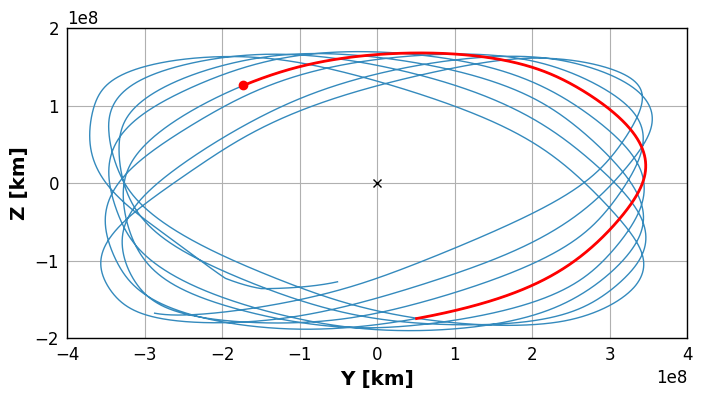

In [5]:
plt.plot(SC_Y,SC_Z)
plt.plot(0,0,marker='x',color='k')

trange = (57450,57550)
trange = (SC_T >= trange[0])*(SC_T <= trange[1])
plt.plot(SC_Y[trange],SC_Z[trange],color='r',linewidth=2)

start = np.min(np.where(trange))
plt.plot(SC_Y[start],SC_Z[start],color='r',linewidth=2,marker='o')

plt.xlabel("Y [km]")
plt.ylabel("Z [km]")


plt.xticks(np.arange(-4e8,4.1e8,1e8))
plt.yticks(np.arange(-2e8,2.1e8,1e8))

plt.xlim(-4e8,4e8)
plt.ylim(-2e8,2e8)

plt.gca().set_aspect('equal')

Given a range of times (in MJD), we can plot the orbit of Gaia as well. The red circle above corresponds to the starting point.

# Fluxes in SM

Load PPE counters for one chip, and SM-SIF data for all chips.

In [6]:
#(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV1_ROW1.dat')
#(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV2_ROW1.dat')
inarr = fits.getdata('../output/Fluxes/FLUX_SM-PPE.fits',extname='ROW_1FOV_1')
t_P = inarr["TIME"]
f_P = inarr["FLUX"]
err_P = inarr["FLUX_ERR"]

In [7]:
#(t_S,n_S,f_S,err_S) = fits_flux(allpaths)

# for SM: load flux for every chip at once
t_S = []
f_S = []
err_S = []

hdulist = fits.open('../output/Fluxes/FLUX_SM-SIF.fits')

for h in hdulist[1:]:
    t_S += list(h.data["TIME"])
    f_S += list(h.data["FLUX"])
    err_S += list(h.data["FLUX_ERR"])
        
hdulist.close()

# then sort by time
sorter = sorted((zip(t_S,f_S,err_S)),key = lambda x: x[0])

t_S = np.array([s[0] for s in sorter])
f_S = np.array([s[1] for s in sorter])
err_S = np.array([s[2] for s in sorter])

# BAM

Load data from the BAM FOV1 from BAM-OBS and BAM-SIF

In [8]:
inarr = fits.getdata('../output/Fluxes/FLUX_BAM-OBS.fits',1)

t_B1_full = inarr["TIME"]
f_B1_full = inarr["FLUX"]
err_B1_full = inarr["FLUX_ERR"]

In [9]:
inarr = fits.getdata('../output/Fluxes/FLUX_BAM-SIF.fits',1)

t_BS1 = inarr["TIME"]
f_BS1 = inarr["FLUX"]
err_BS1 = inarr["FLUX_ERR"]

We rebin the BAM data by a factor of 10, reaching a similar effective exposure time as the PPEs

In [10]:
rebin_fac = 10

t_B1,f_B1,err_B1 = rebin_fluxes((t_B1_full,f_B1_full,err_B1_full), rebin_fac)

# Flux plots

This routine defines the following plots

In [11]:
def flareplot(tstart,tstop,stepping,ybam=(1,100),ysm=(1,100),yext=(.05,500),log=True,turns=None,savefile=''):
    t1,f1,err1 = MJD_cutout(t_B1,f_B1,err_B1,tstart,tstop,stepping)
    t2,f2,err2 = MJD_cutout(t_BS1,f_BS1,err_BS1,tstart,tstop,1)
    t3,f3,err3 = MJD_cutout(t_P,f_P,err_P,   tstart,tstop,stepping)
    t4,f4,err4 = MJD_cutout(t_S,f_S,err_S,   tstart,tstop,1)

    fig, (axbam, axsm, axext) = plt.subplots(nrows=3,sharex=True)
    
    axbam.errorbar(t1, f1, yerr=err1*0, linestyle='', marker='x', color='xkcd:red', label="BAM-OBS1")
    if len(t2>0):
        axbam.errorbar(t2, f2, yerr=err2*0, linestyle='', marker='x', color='xkcd:faded blue', label="BAM-SIF1")
    
    if len(t4>0):
        axsm.errorbar(t4, f4, yerr=err4, linestyle='', marker='x', color='xkcd:tree green', label="SM-SIF")
    axsm.errorbar(t3, f3, yerr=err3, linestyle='', marker='x', color='xkcd:amethyst', label="SM-PPE")
    
    #axext.plot(t_goes[::30], f_goes[2][::30], linestyle='', marker='x', color='xkcd:amethyst', label="GOES > 10 MeV")
    axext.plot(t_ace, f_ace[0], linestyle='', marker='x', color='xkcd:red', label="ACE > 10 MeV")
    axext.plot(t_ace, f_ace[1], linestyle='', marker='x', color='xkcd:faded blue', label="ACE > 30 MeV")
    
    # if available: mark the points where gaia does a full revolution
    if not (turns is None):
        axbam.plot(turns,np.ones(turns.shape)*ybam[0], linestyle='', marker='d',color='k')
        axsm.plot(turns,np.ones(turns.shape)*ysm[0], linestyle='', marker='d',color='k')

    # logarithmic axes
    if log==True:
        axbam.set_yscale('log')
        axsm.set_yscale('log')
        axext.set_yscale('log')
    
    axbam.legend(loc='upper right')
    axsm.legend(loc='upper right')
    axext.legend(loc='upper right')

    axbam.set_ylim(ybam)
    axbam.set_ylabel("Flux\n[parts/s/cm^2]")

    axsm.set_ylim(ysm)
    axsm.set_ylabel("Flux\n[parts/s/cm^2]")

    axext.set_ylim(yext)
    axext.set_ylabel("Flux\n [parts/sr/s/cm^2]")
    axext.set_xlabel("MJD")

    axbam.set_xlim(tstart,tstop)

    plt.gcf().set_size_inches(15,7.5)
    
    if savefile != '':
        plt.savefig(savefile,bbox_inches='tight')

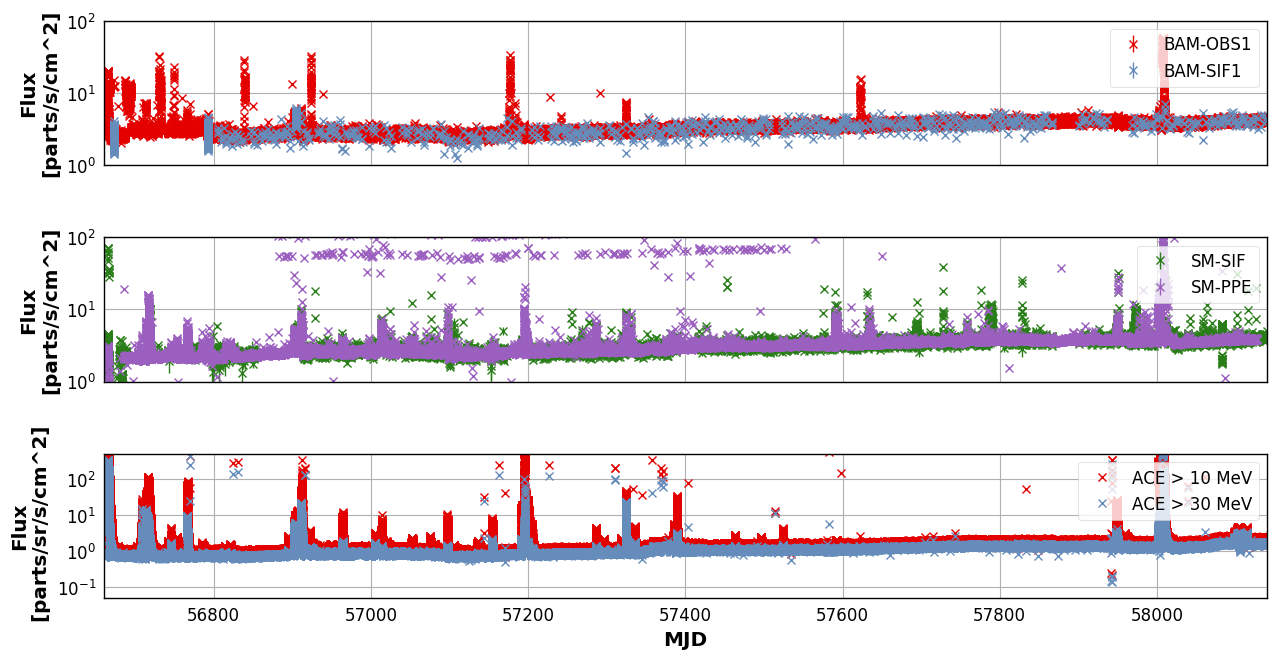

In [12]:
#tstart,tstop  = (57150,57200)
#tstart,tstop  = (58000,58015) # Sept '17 Flare
#tstart,tstop = (57945,57955)  # Jul '17 Flare
#tstart,tstop = (56901,56915) # Sept '14
#tstart,tstop = (56880,57050)
#tstart,tstop = (57930,57945) # quiet period
#tstart,tstop = (57632,57636) # strong stray light modulation

#otimes = [OBMT_apyTime(t).mjd for t in t_S]

flareplot(min(t_S),max(t_S),10)#,savefile='../../presentation_imgs/flux_full_mission.png')

This plot spans the entirety of the mission. From top to bottom, the panels show

- BAM data (OBS and SIF)
- SM data (PPE and SIF)
- ACE data (two energy ranges)

We notice that data from the same chip are consistent, and all data follow the trend of an increasing baseline flux - this corresponds to the galactic cosmic rays, which become more prominent as we move towards solar minimum

We can also plot the orbit during the whole mission.

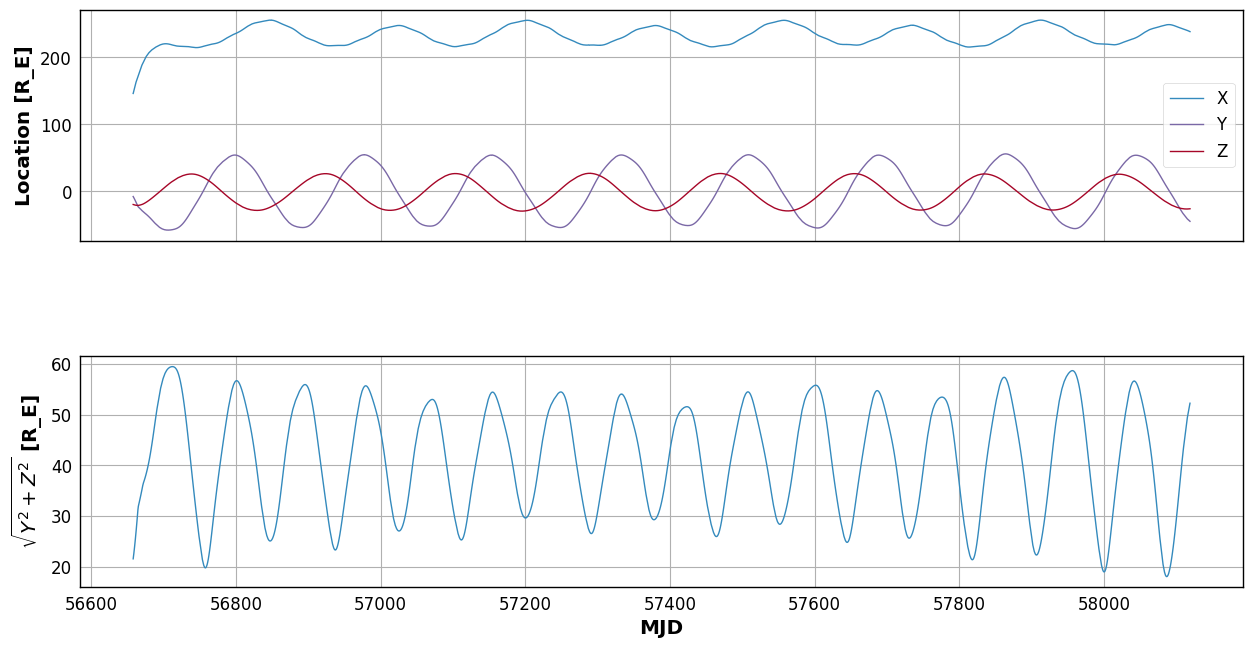

In [24]:
fig, axes = plt.subplots(nrows=2,sharex=True)

Rearth = 6.371e6

axes[0].plot(SC_T,(SC_X )/Rearth, label='X')
axes[0].plot(SC_T,SC_Y/Rearth, label='Y')
axes[0].plot(SC_T,SC_Z/Rearth, label='Z')

axes[0].legend(loc='best')
axes[0].set_ylabel("Location [R_E]")

axes[1].plot(SC_T,np.sqrt(SC_Y**2+SC_Z**2)/Rearth)
axes[1].set_ylabel(r"$\sqrt{Y^2 + Z^2}$ [R_E]")

axes[-1].set_xlabel("MJD")
fig.set_size_inches(15,7.5)

We'll look at periods of 200 days and then zoom in on whatever we find

## Beginning - 56800

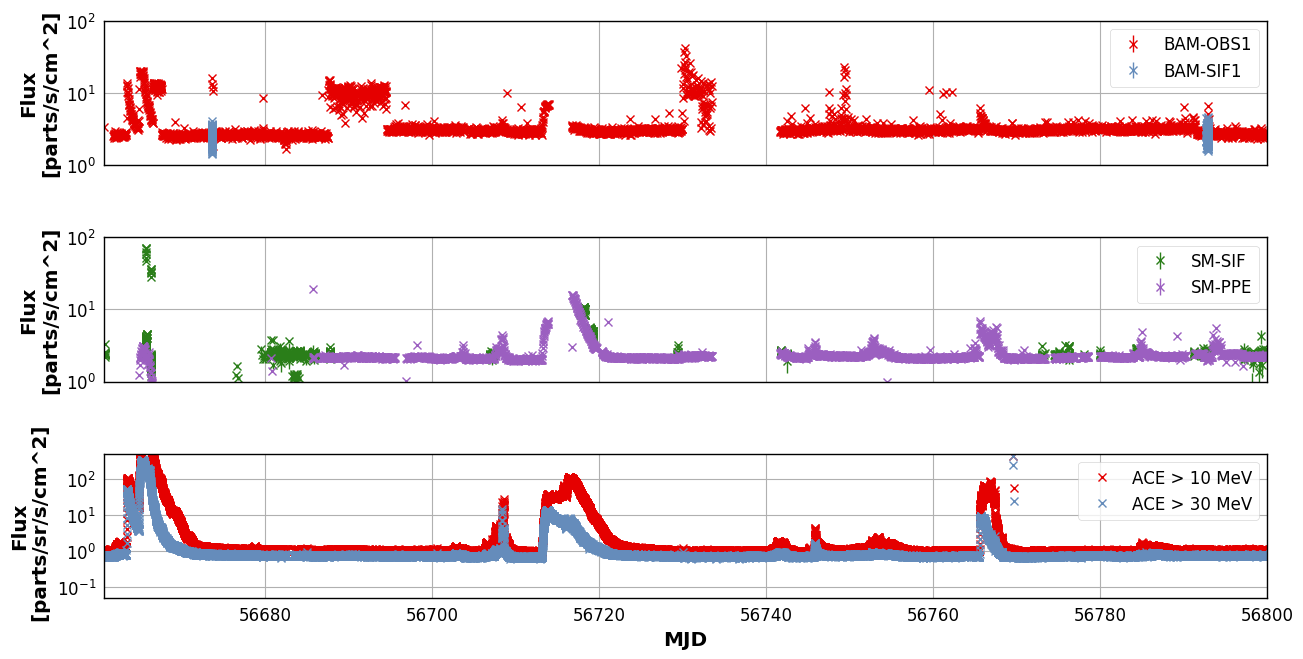

In [25]:
flareplot(min(t_B1),56800,10)

During the beginning of the mission, there are a lot of data gaps and issues with BAM. This was during comissioning, so the data is not very valuable.

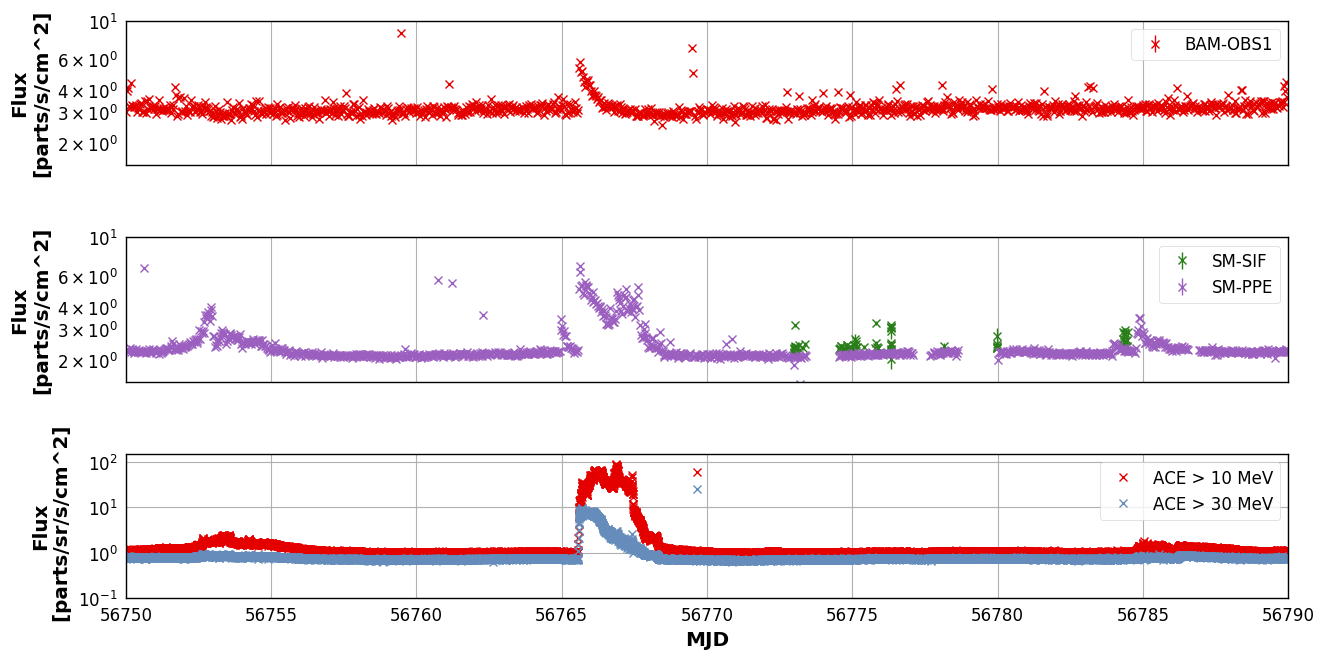

In [27]:
flareplot(56750,56790,10,ybam=(1.5,10),ysm=(1.5,10),yext=(.1,150))

Interesting dip in the middle of SM?

Something that becomes quite clear here: BAM and SM see the flares very differently. This would indicate a difference in shielding, and that the BAM is not sensitive to low energy particles (compare the ACE curves vs SM and BAM)

## 56800 - 57000

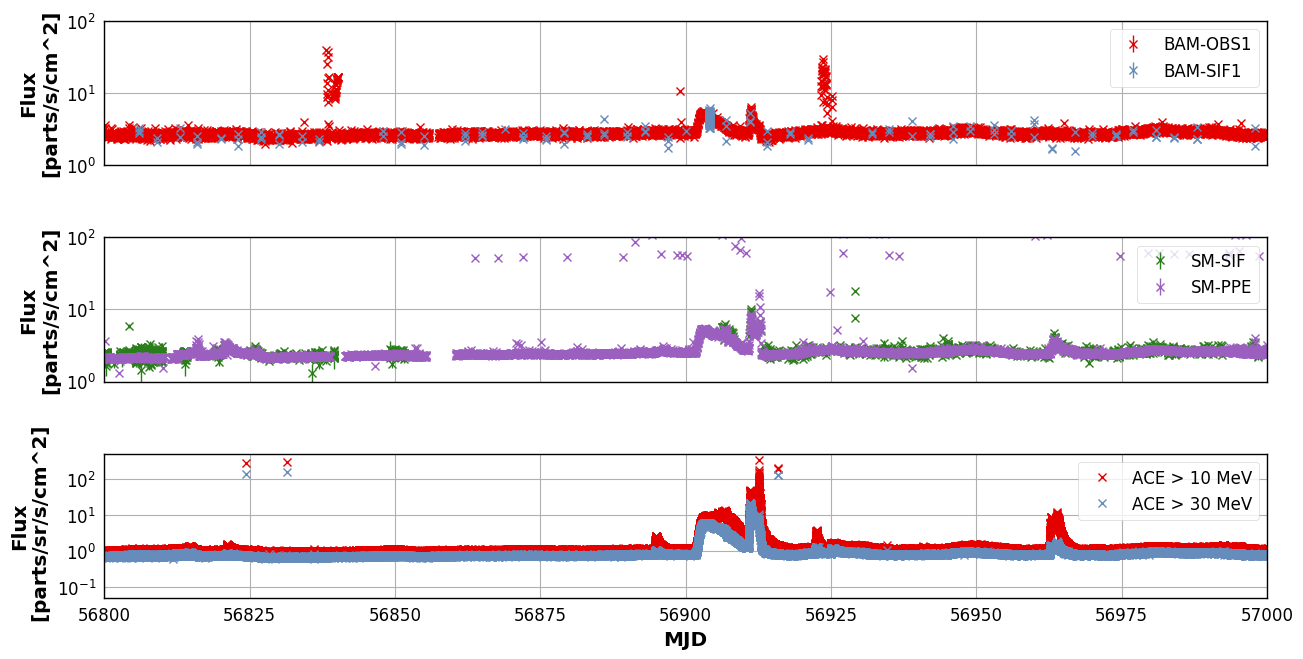

In [28]:
flareplot(56800,57000,10)

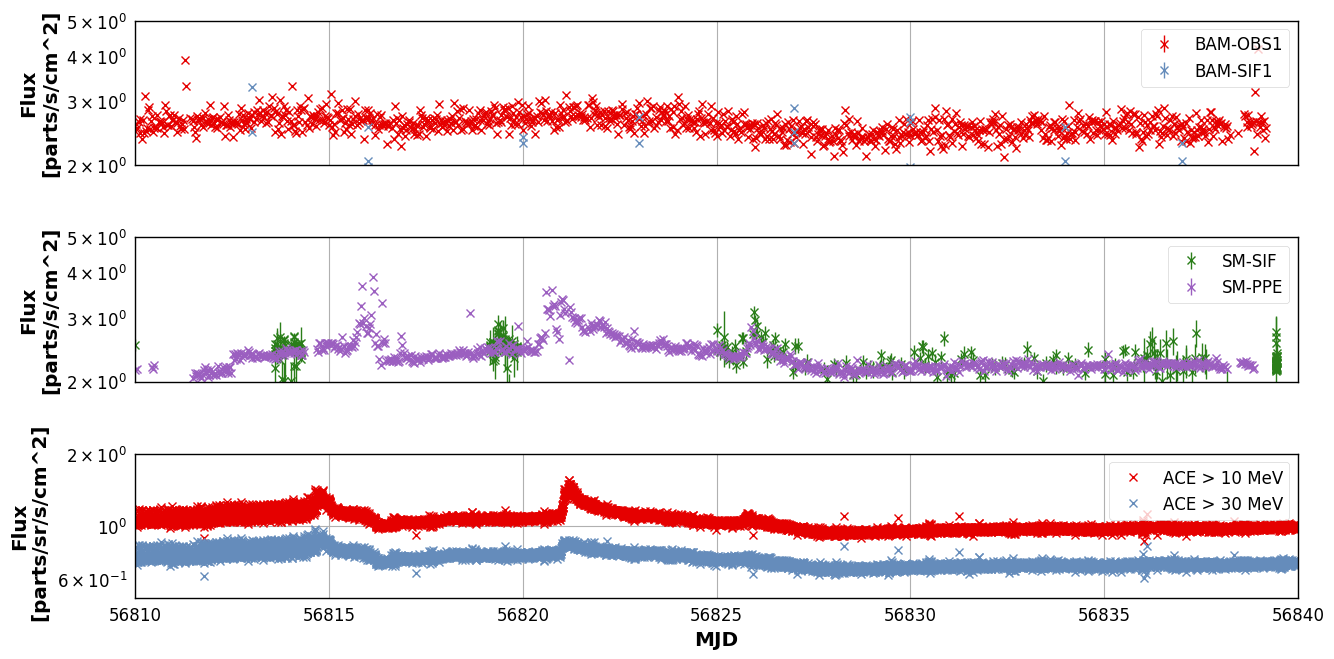

In [29]:
flareplot(56810,56840,10,ybam=(2,5),ysm=(2,5),yext=(.5,2),log=True)

There seem to be some arrival time delays here?

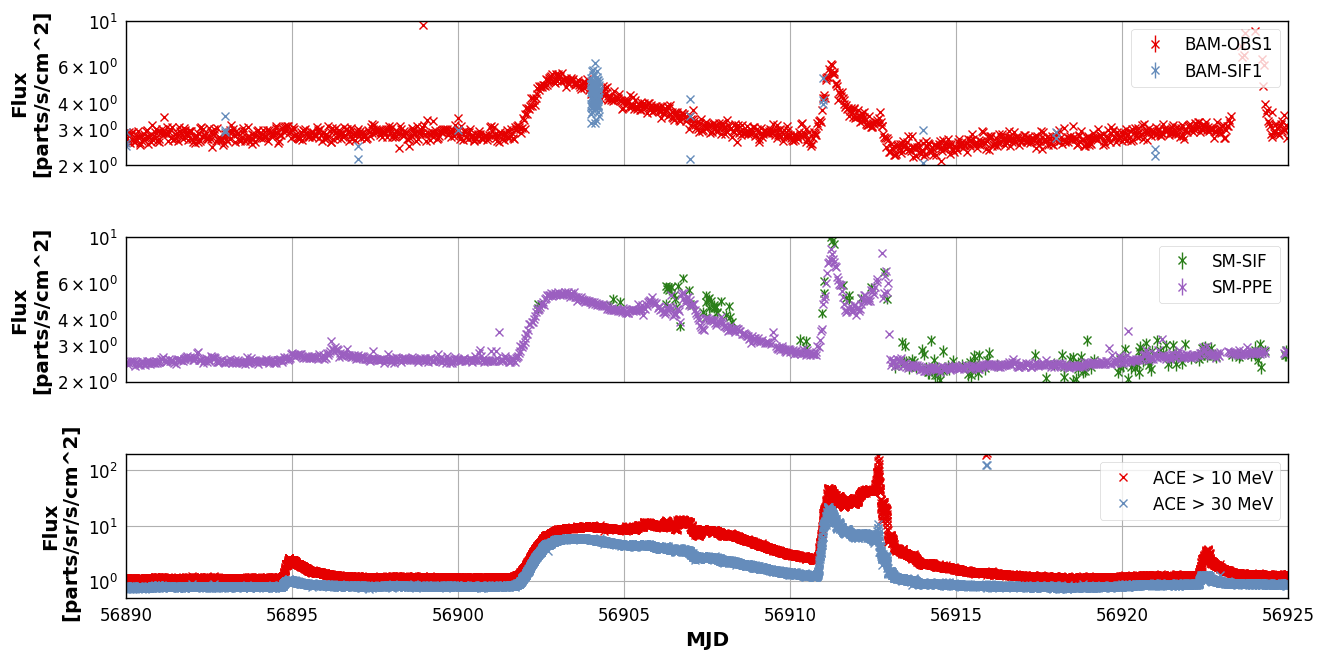

In [30]:
flareplot(56890,56925,10,ybam=(2,10),ysm=(2,10),yext=(.5,200))

Nice how SM also sees a 'wiggle' in the precursor. The double-peaked thing sould be interesting to study.

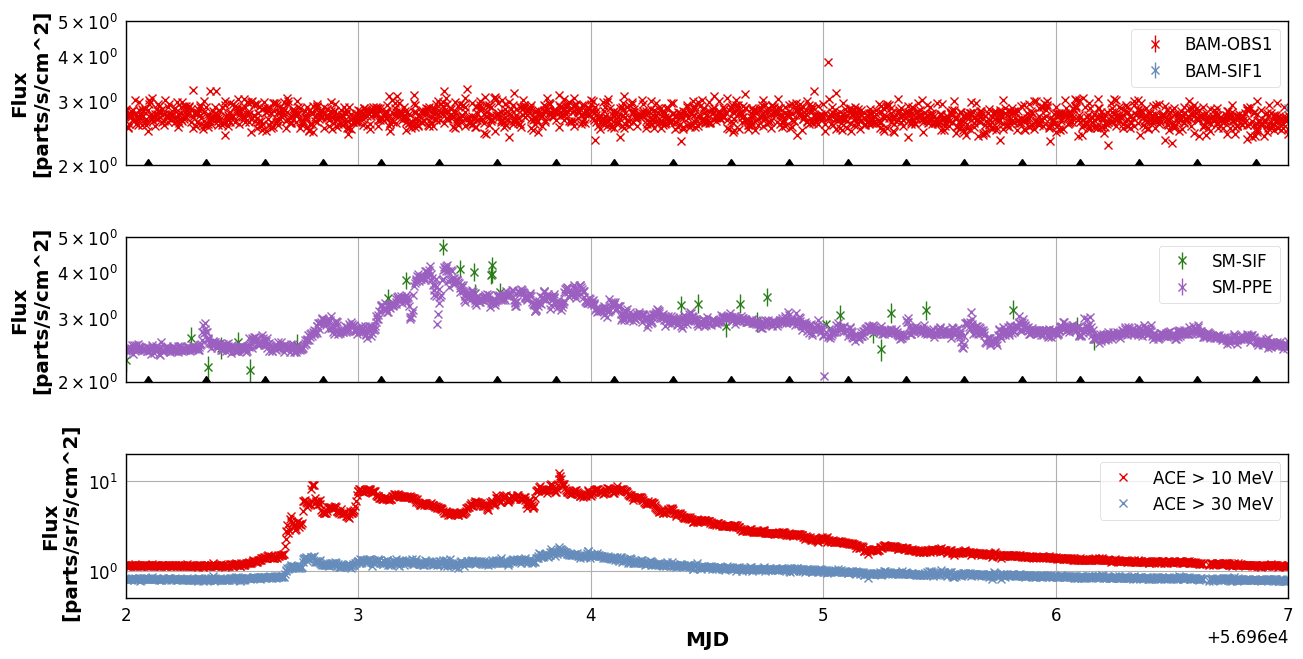

In [33]:
flareplot(56962,56967,1,ybam=(2,5),ysm=(2,5),yext=(.5,20),log=True,turns=spinturns)

This also looks like there's some different timing, no?

Additionally, the diamonds plotted here reference the spinturns - i.e. when the FPA is facing the sun. There appear to be some associated modulations.

## 57000 - 57200

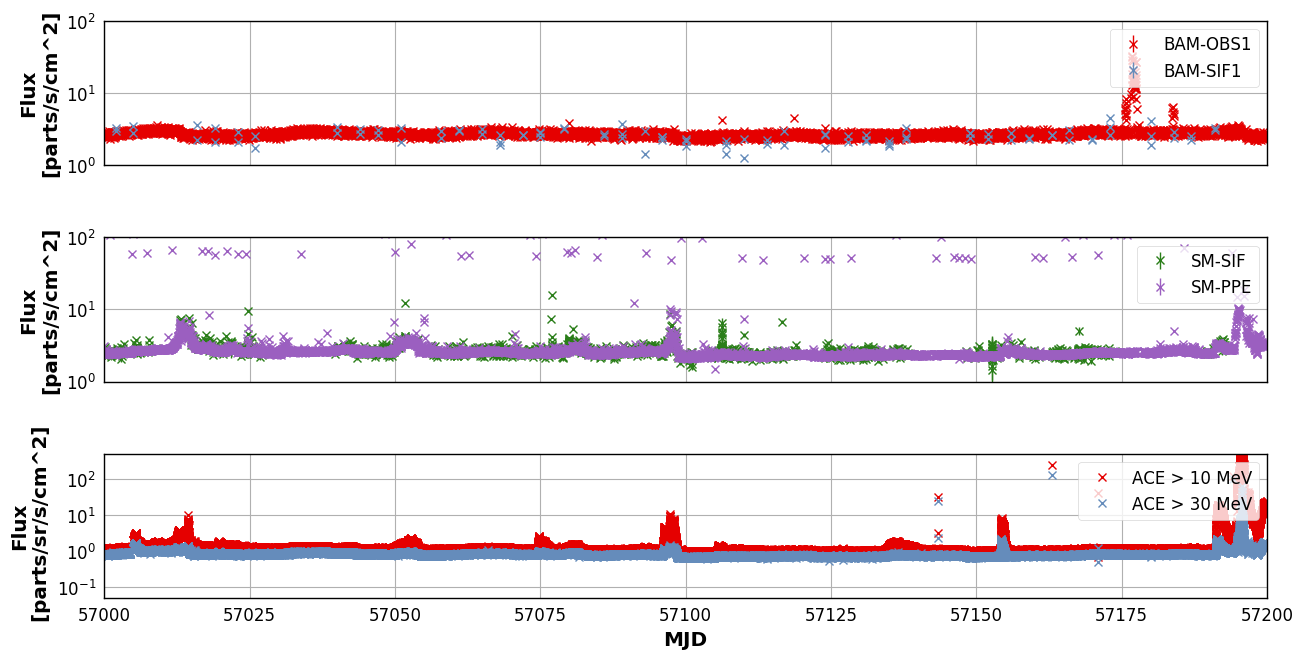

In [34]:
flareplot(57000,57200,10)

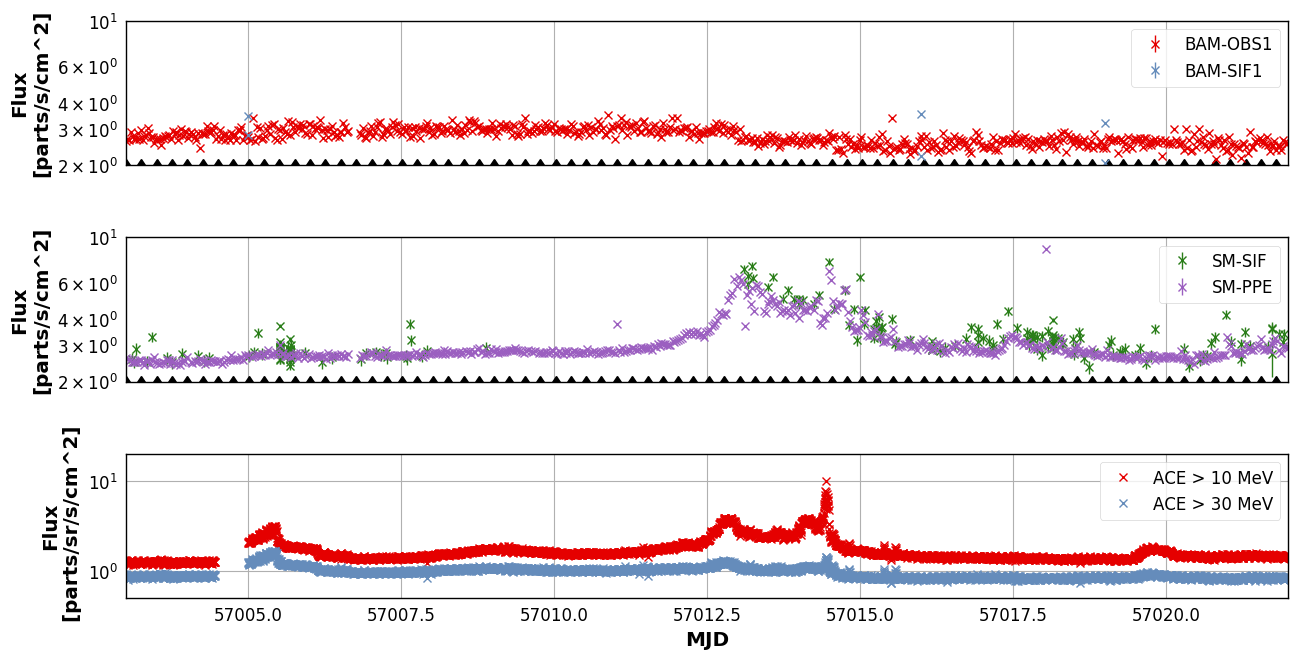

In [35]:
flareplot(57003,57022,10,ybam=(2,10),ysm=(2,10),yext=(.5,20),turns=spinturns)

Flare around 57005 is not picked up at all?

BAM actually does see some flaring, although the point at which the countrates go down is strange.

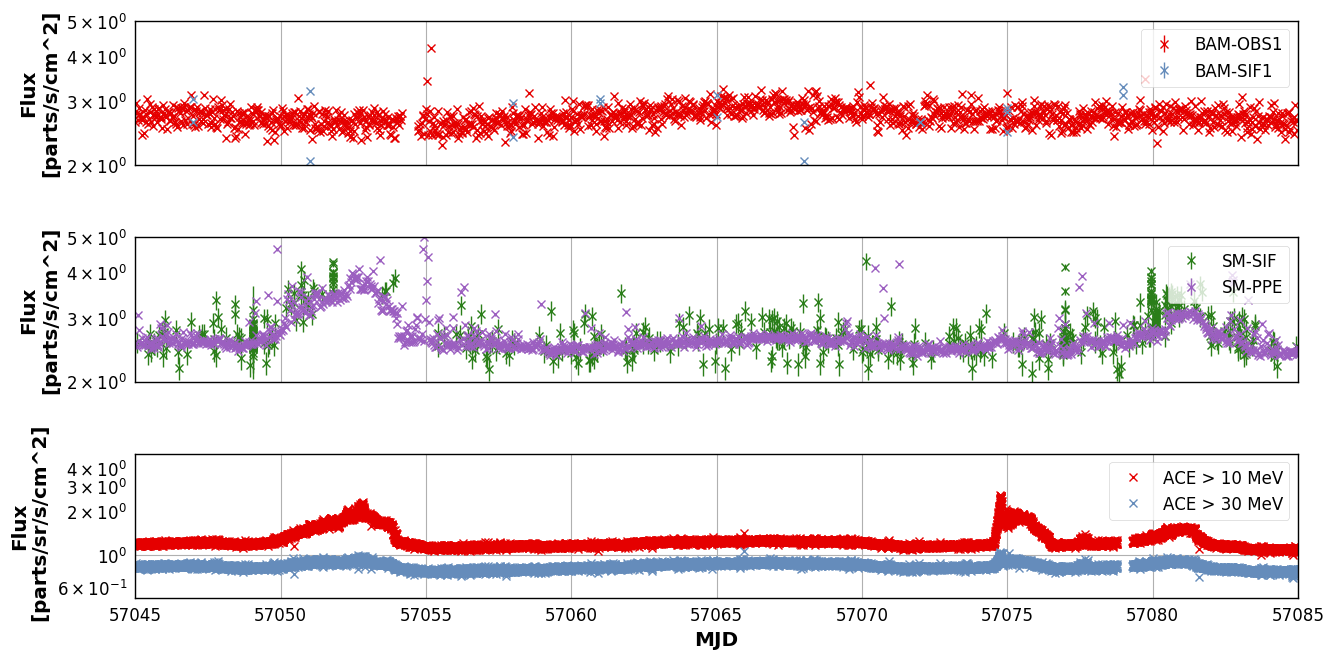

In [36]:
flareplot(57045,57085,10,ybam=(2,5),ysm=(2,5),yext=(.5,5))

The second flare is really interesting - SM vs ACE show different relative peaks.

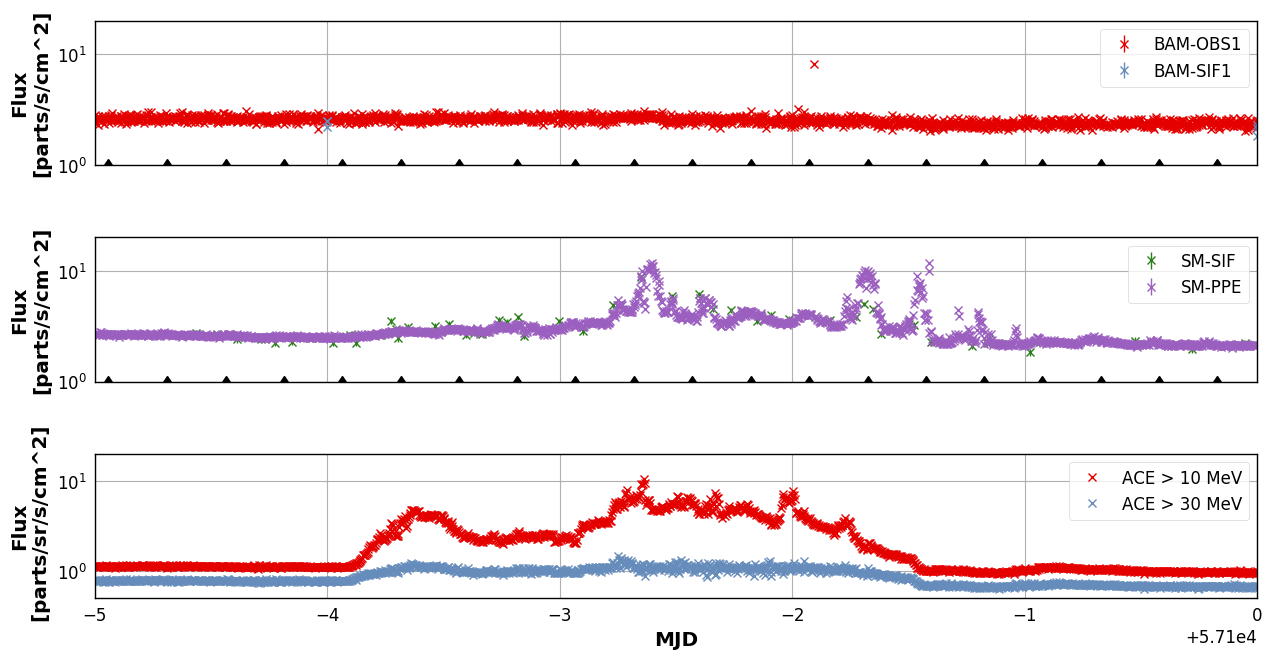

In [37]:
flareplot(57095,57100,1,ybam=(1,20),ysm=(1,20),yext=(.5,20),log=True,turns=spinturns)

Timing difference?

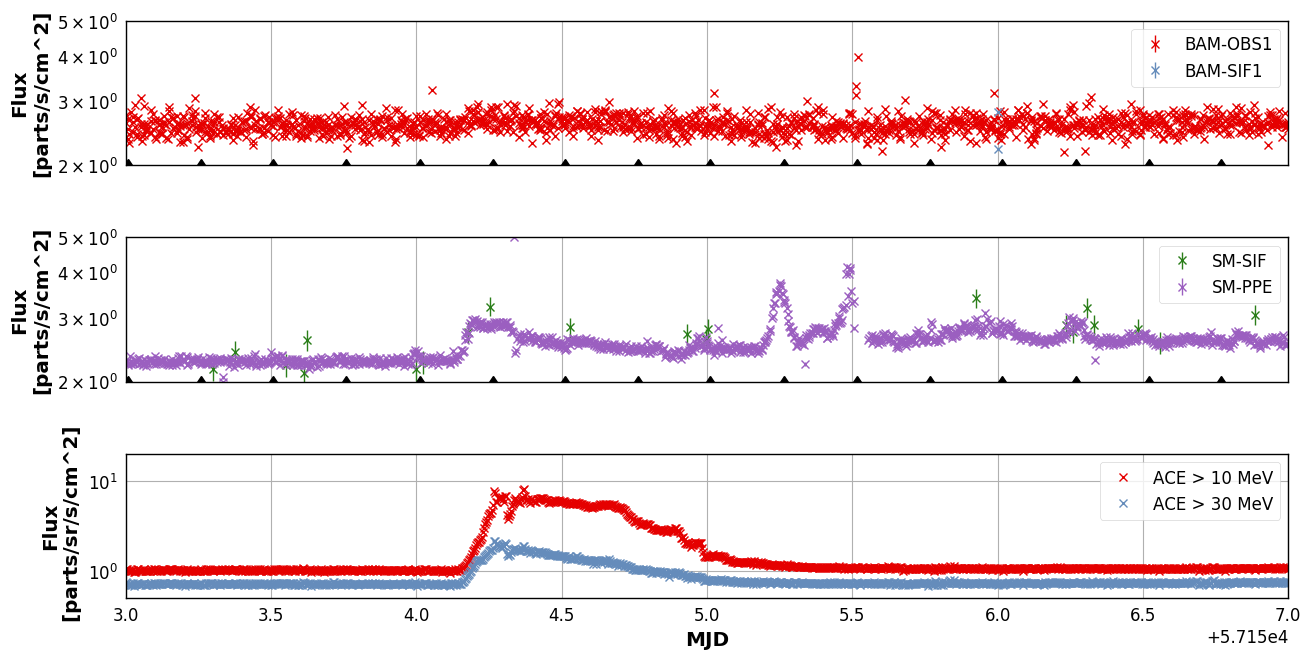

In [38]:
flareplot(57153,57157,1,ybam=(2,5),ysm=(2,5),yext=(.5,20),turns=spinturns)

Strange structure after the flare proper in SM - associated with rotation?

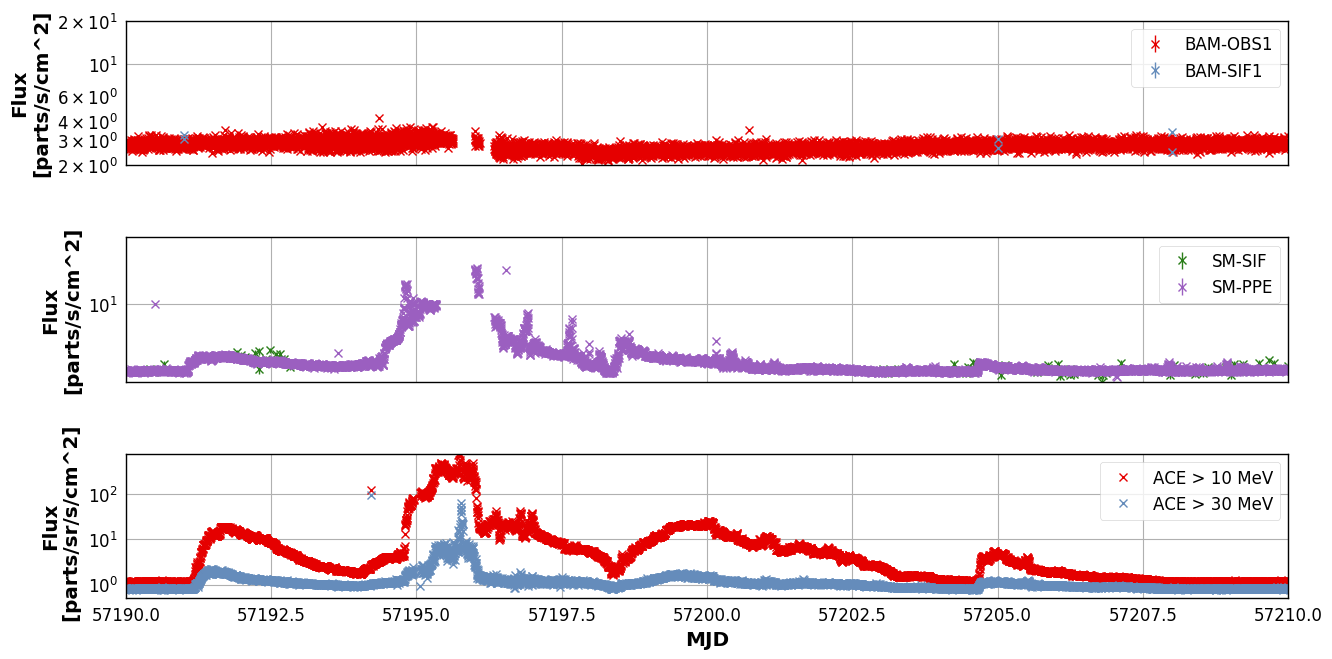

In [39]:
flareplot(57190,57210,1,ybam=(2,20),ysm=(2,40),yext=(.5,800),log=True)

An annoying data gap...

## 57200 - 57400

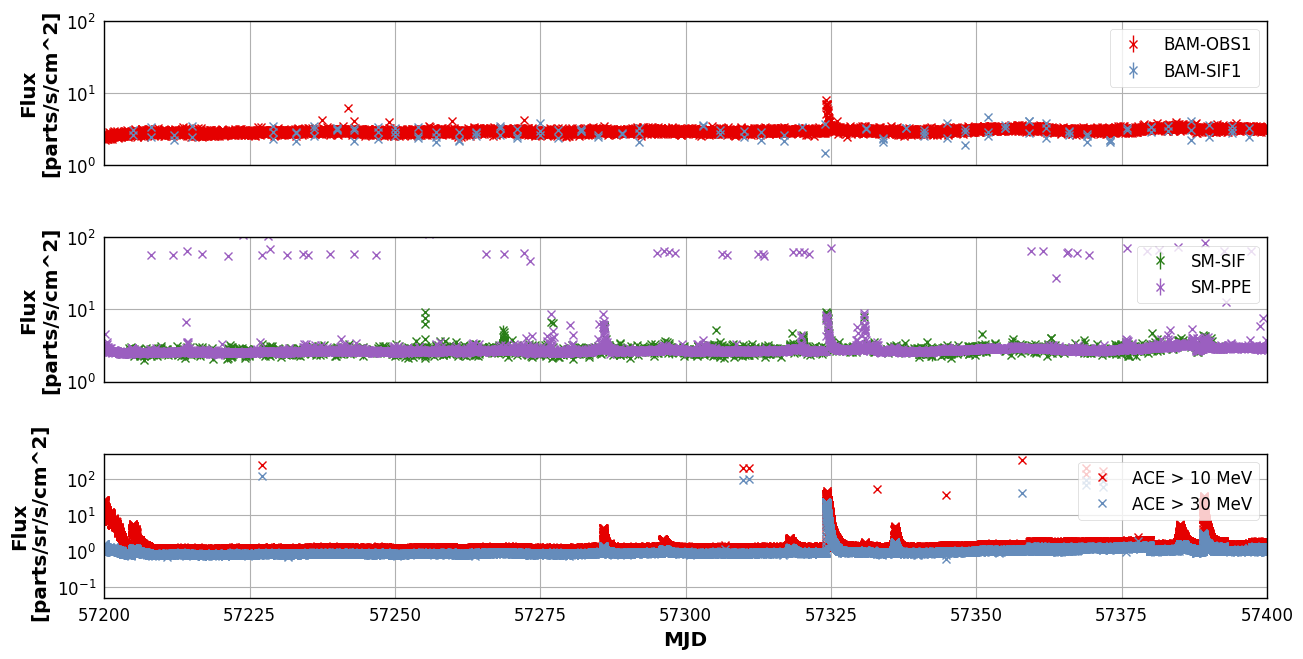

In [40]:
flareplot(57200,57400,10)

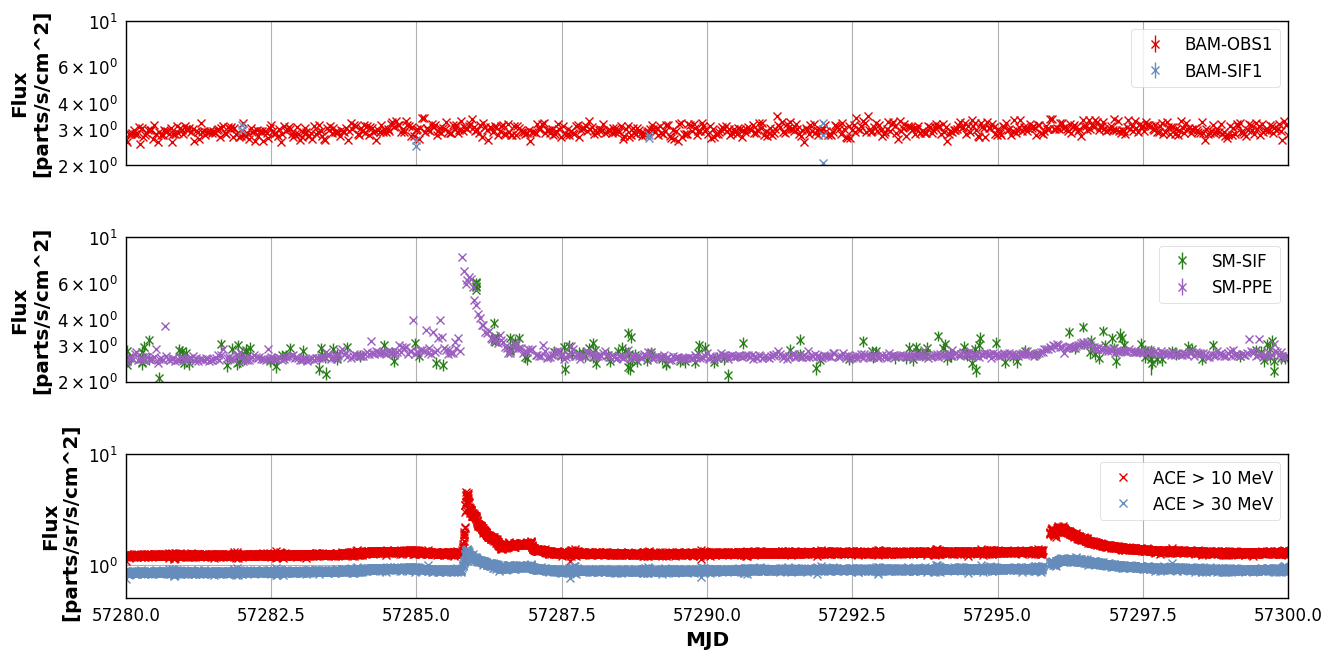

In [41]:
flareplot(57280,57300,10,ybam=(2,10),ysm=(2,10),yext=(.5,10))

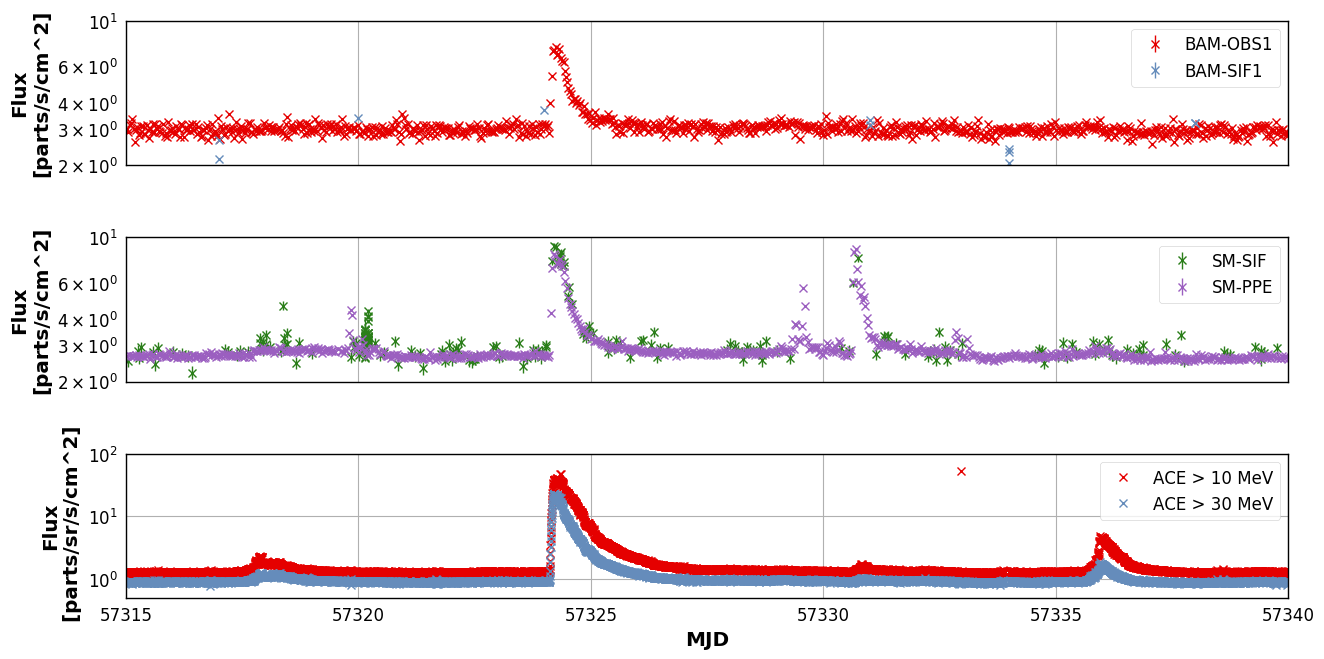

In [42]:
flareplot(57315,57340,10,ybam=(2,10),ysm=(2,10),yext=(.5,100))

Very interesting how the first flare is picked up, but the second almost not at all

Is the peak in the middle for SM just some stars?

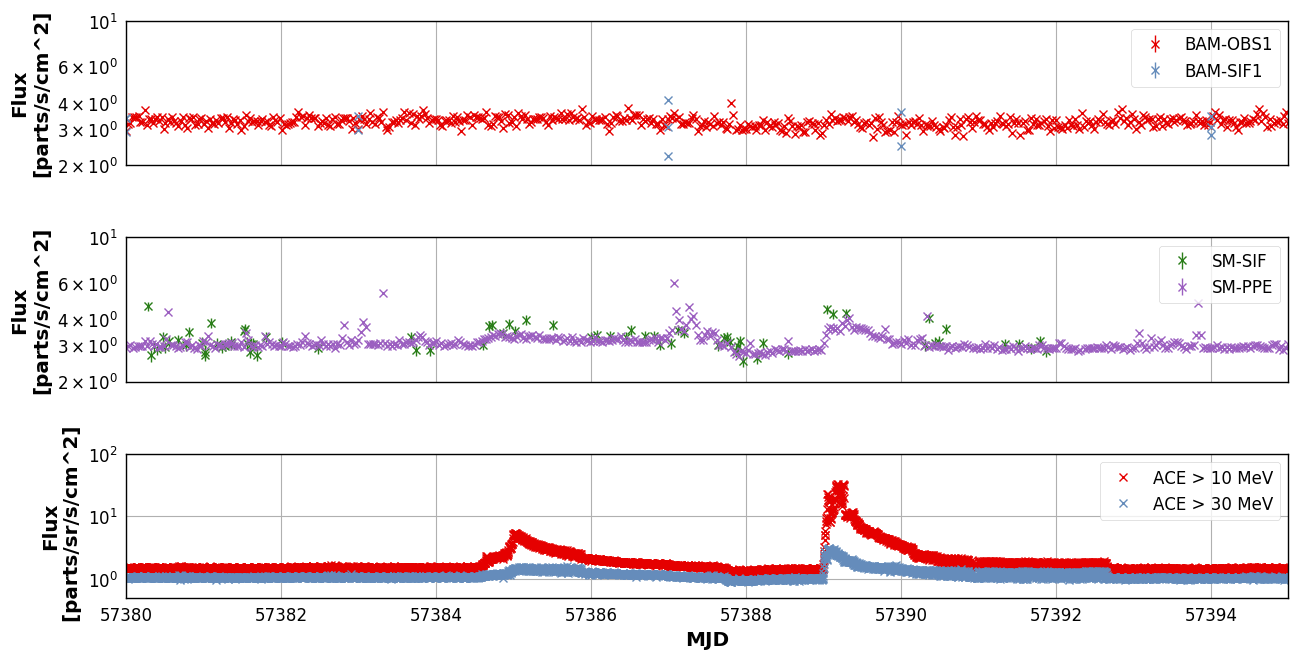

In [43]:
flareplot(57380,57395,10,ybam=(2,10),ysm=(2,10),yext=(.5,100))

SM looks weird here

## 57400 - 57600

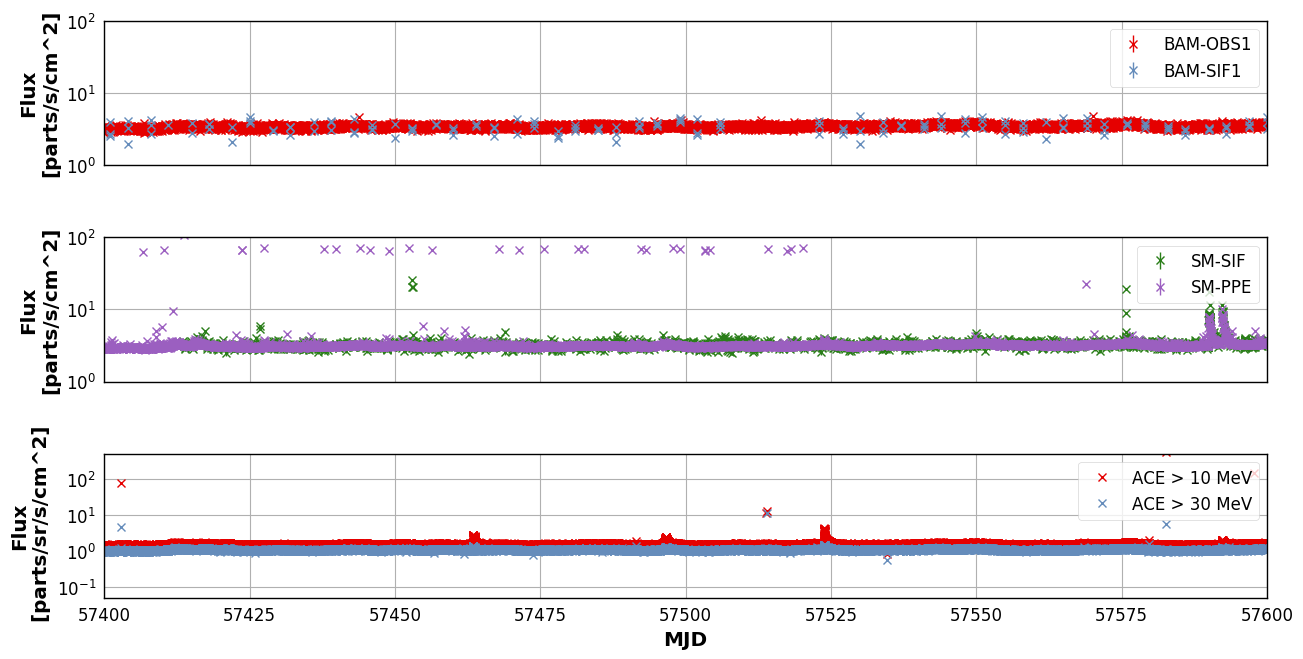

In [44]:
flareplot(57400,57600,10)

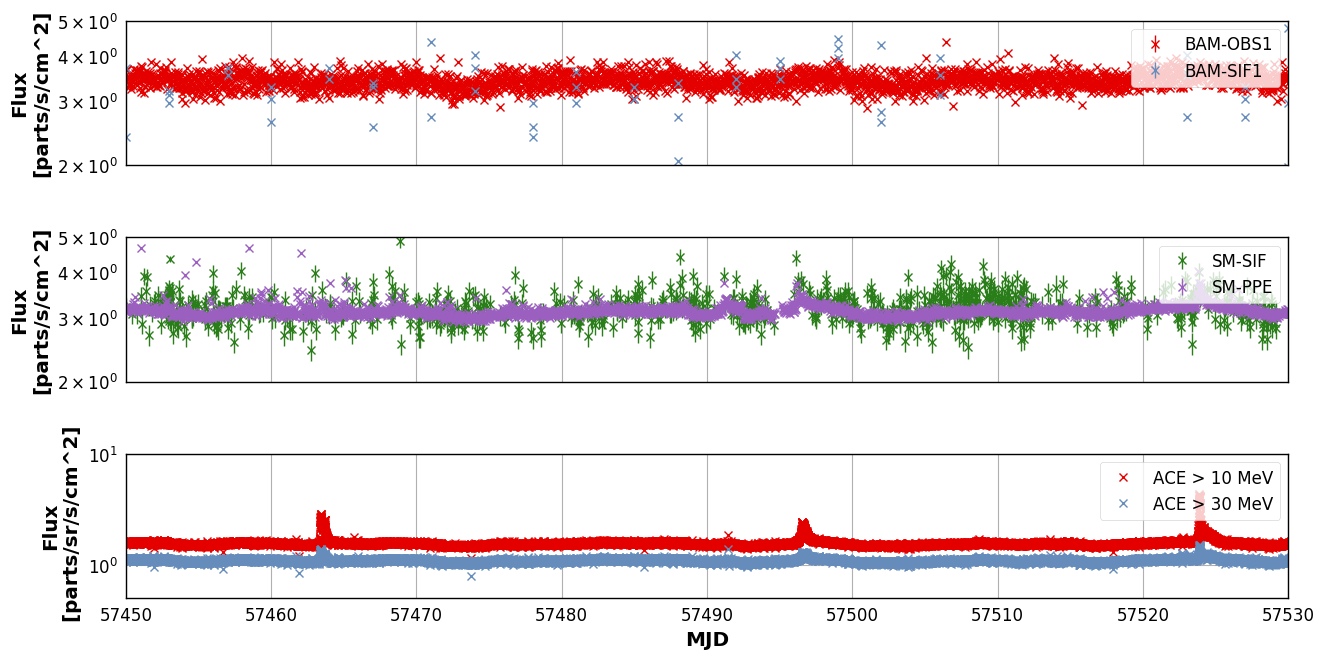

In [45]:
flareplot(57450,57530,10,ybam=(2,5),ysm=(2,5),yext=(.5,10))

Again curious to see when something is picked up or not

## 57600 - 57800

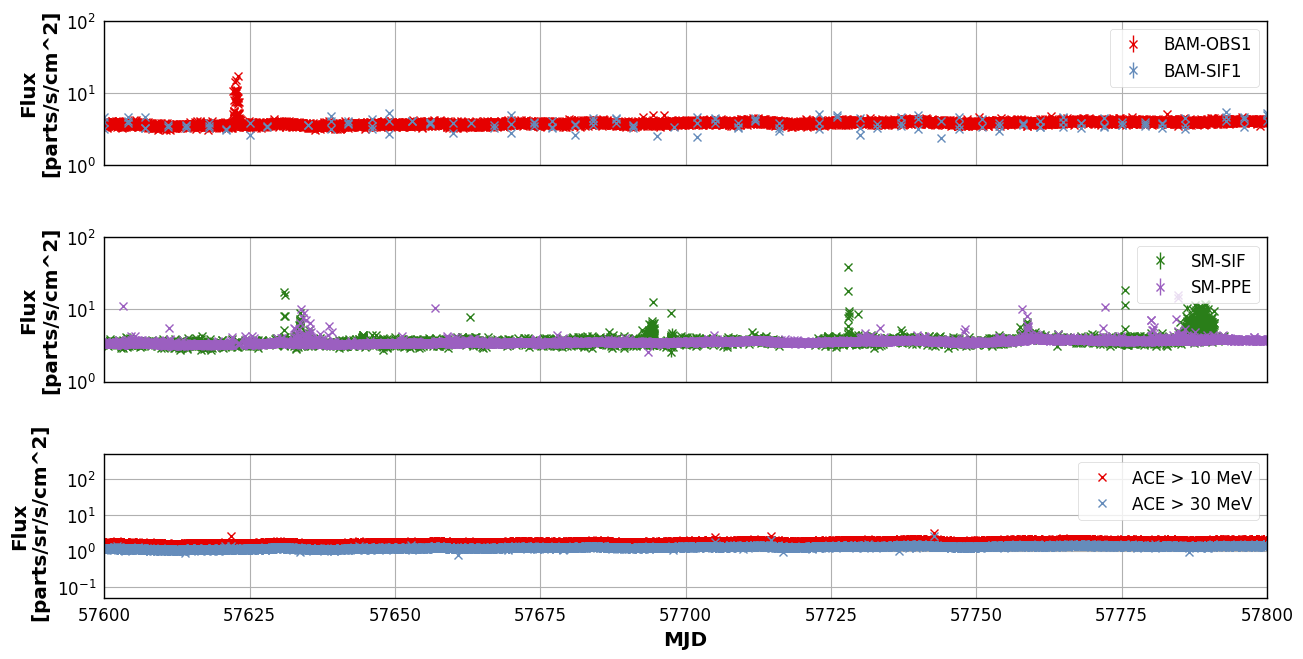

In [46]:
flareplot(57600,57800,10)

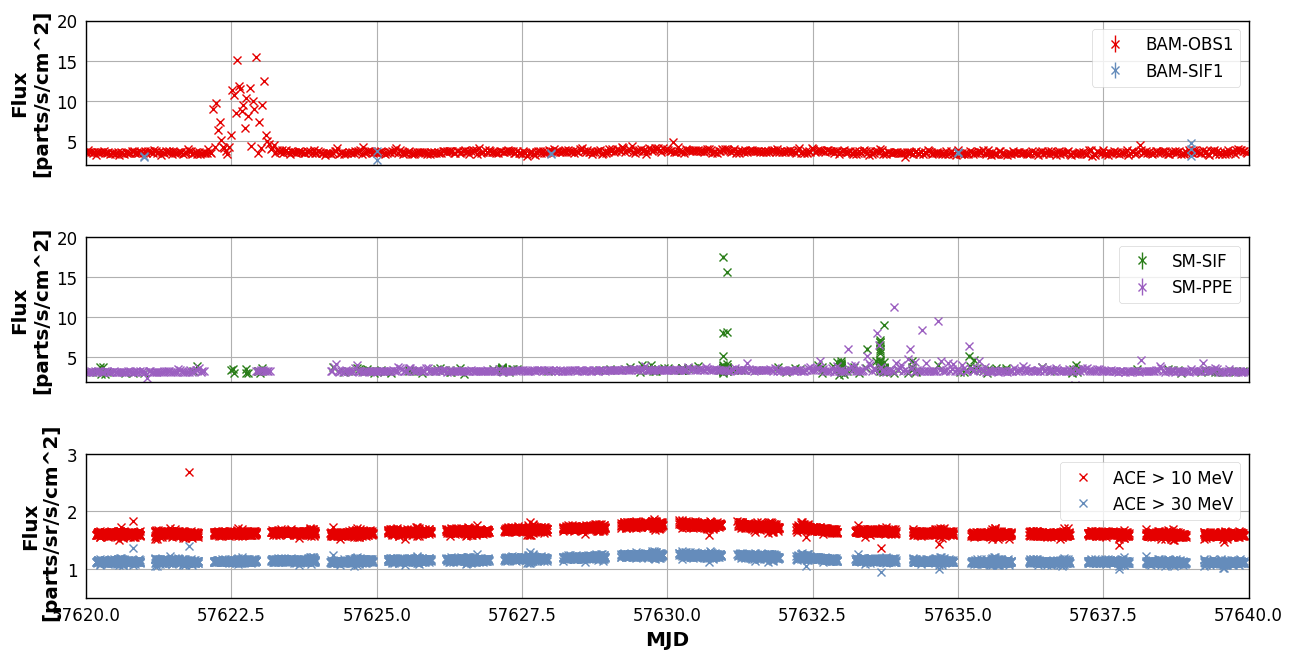

In [47]:
flareplot(57620,57640,10,ybam=(2,20),ysm=(2,20),yext=(.5,3),log=False)

Extra flare in BAM? Probably instrumental things.

## 57800 - 58000

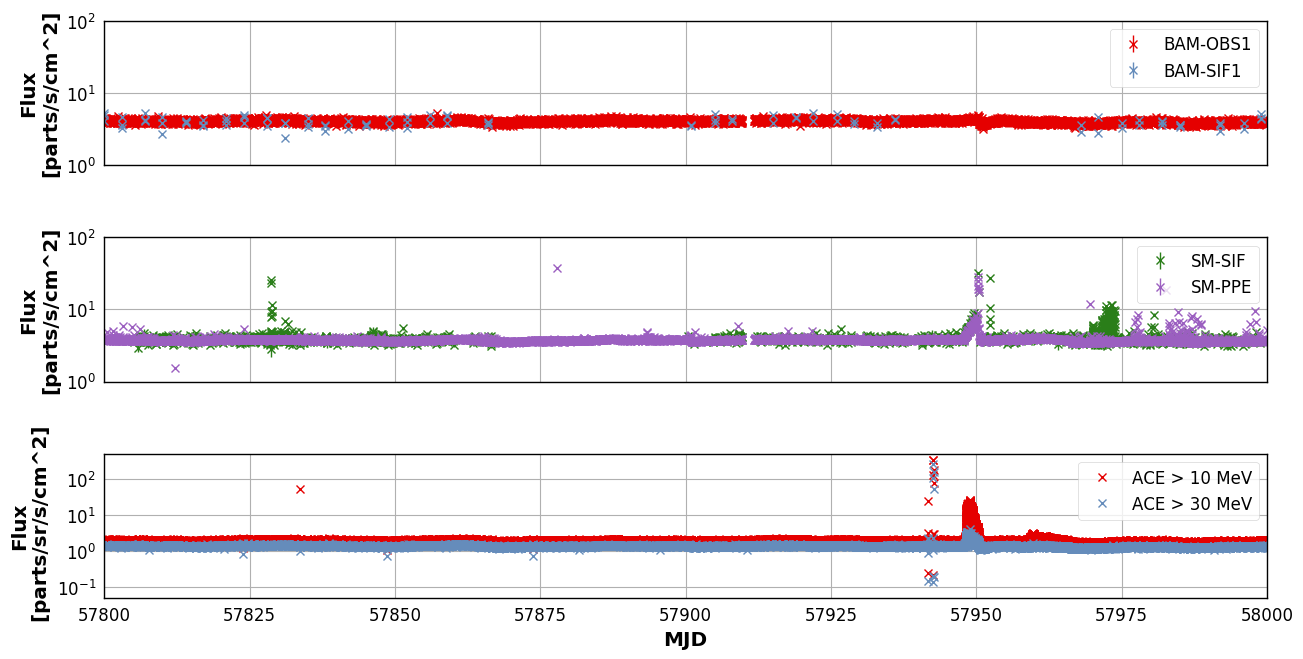

In [48]:
flareplot(57800,58000,10)

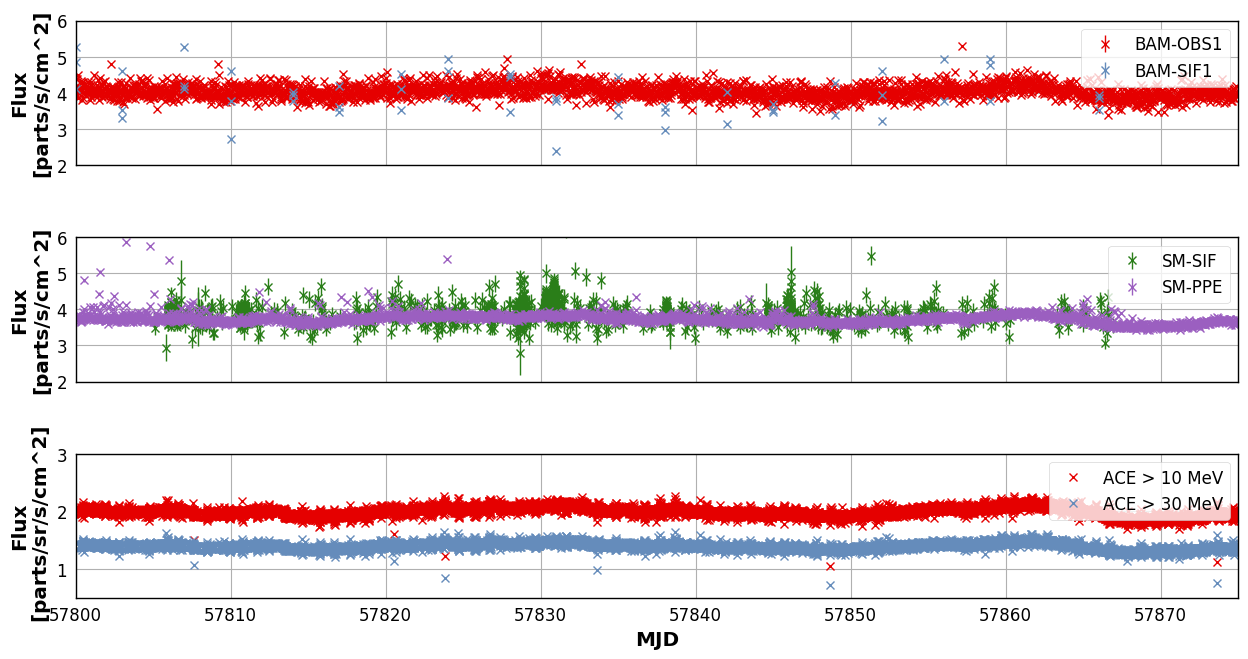

In [49]:
flareplot(57800,57875,10,ybam=(2,6),ysm=(2,6),yext=(.5,3),log=False)

Interesting here: There is some modulation from 57800 to 57875 that's perfectly matched by BAM

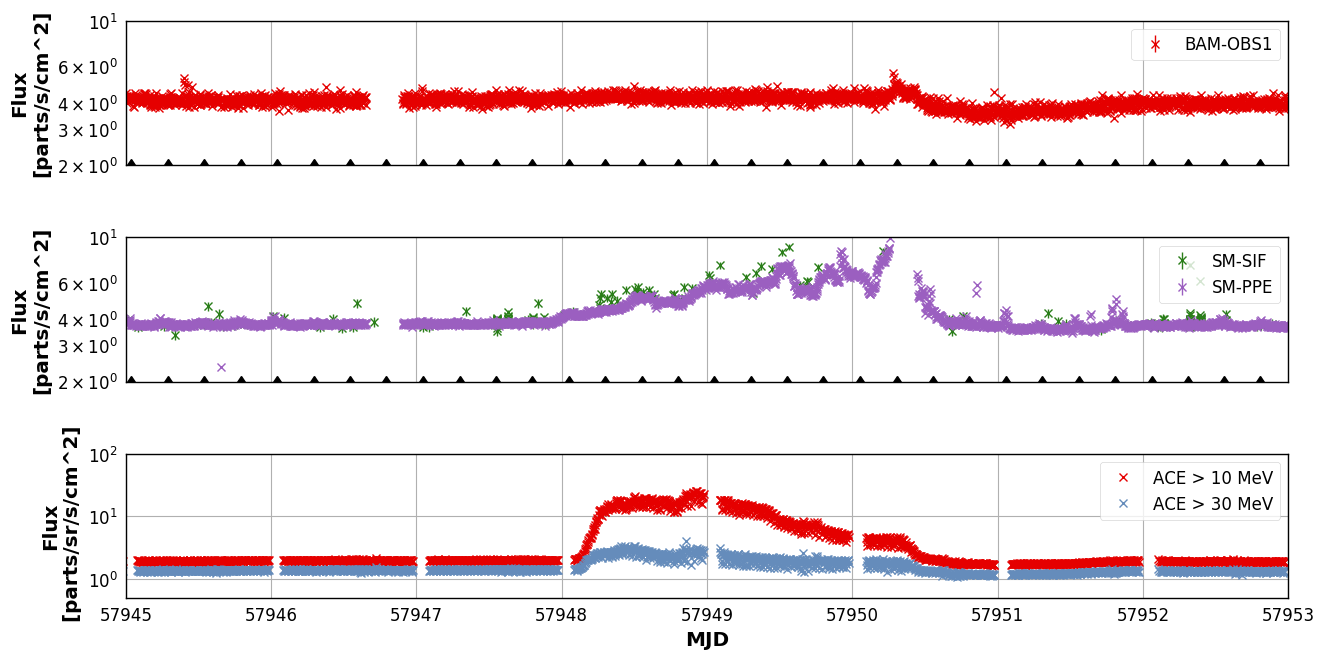

In [50]:
#flareplot(57940,57975,10,ybam=(2,10),ysm=(2,10),yext=(.5,100),log=True)
flareplot(57945,57953,1,ybam=(2,10),ysm=(2,10),yext=(.5,100),log=True,turns=spinturns)

Kink in BAM after the flare. It also looks very interesting in SM vs ACE...

## 58000 - NOW

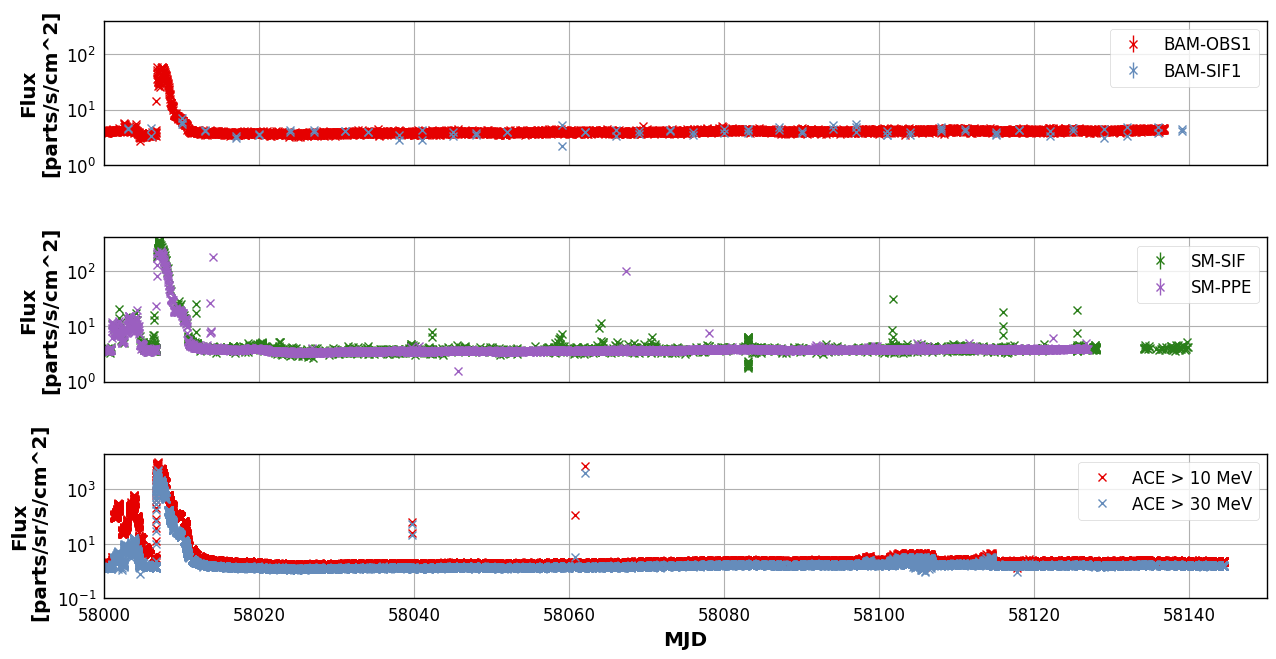

In [51]:
flareplot(58000,58150,10,ybam=(1,400),ysm=(1,400),yext=(.1,20000))

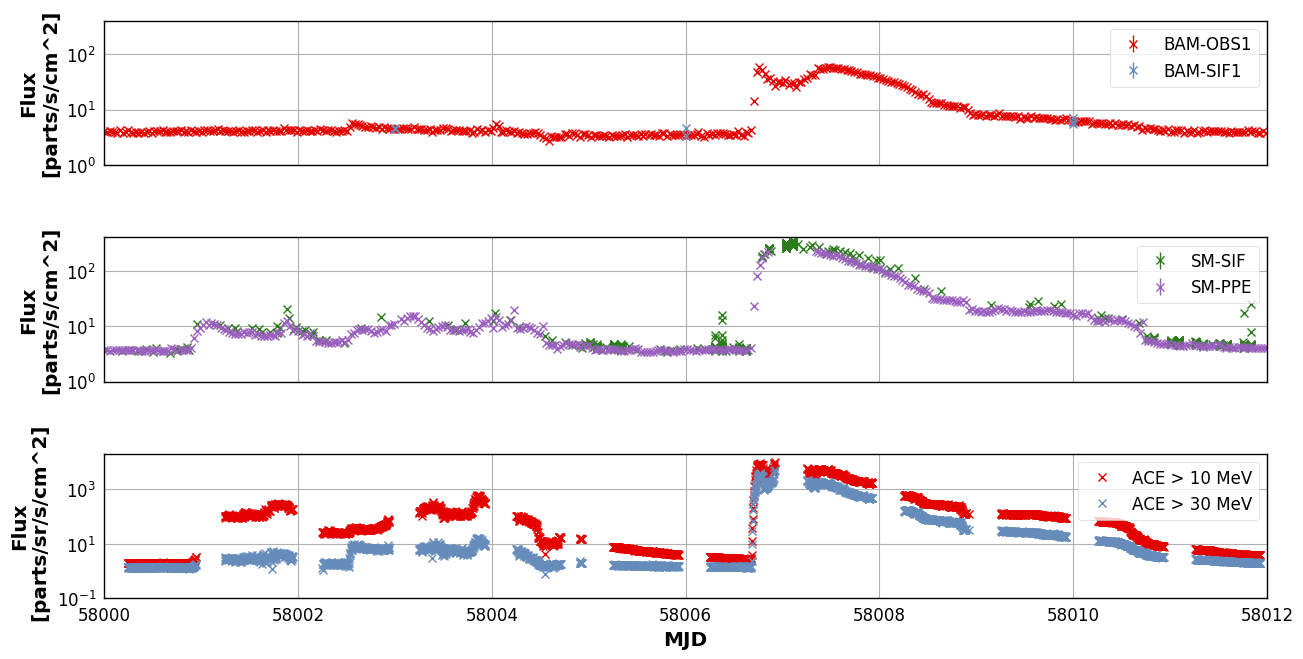

In [52]:
# September 2017
flareplot(58000,58012,10,ybam=(1,400),ysm=(1,400),yext=(.1,20000))

Very interesting precursor. BAM is totally overwhelmed during the flare proper, but we do see some of the kinks in the ACE data as well.

# Some closer looks at the modulations

In [54]:
#(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV1_ROW1.dat')
#(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV2_ROW1.dat')

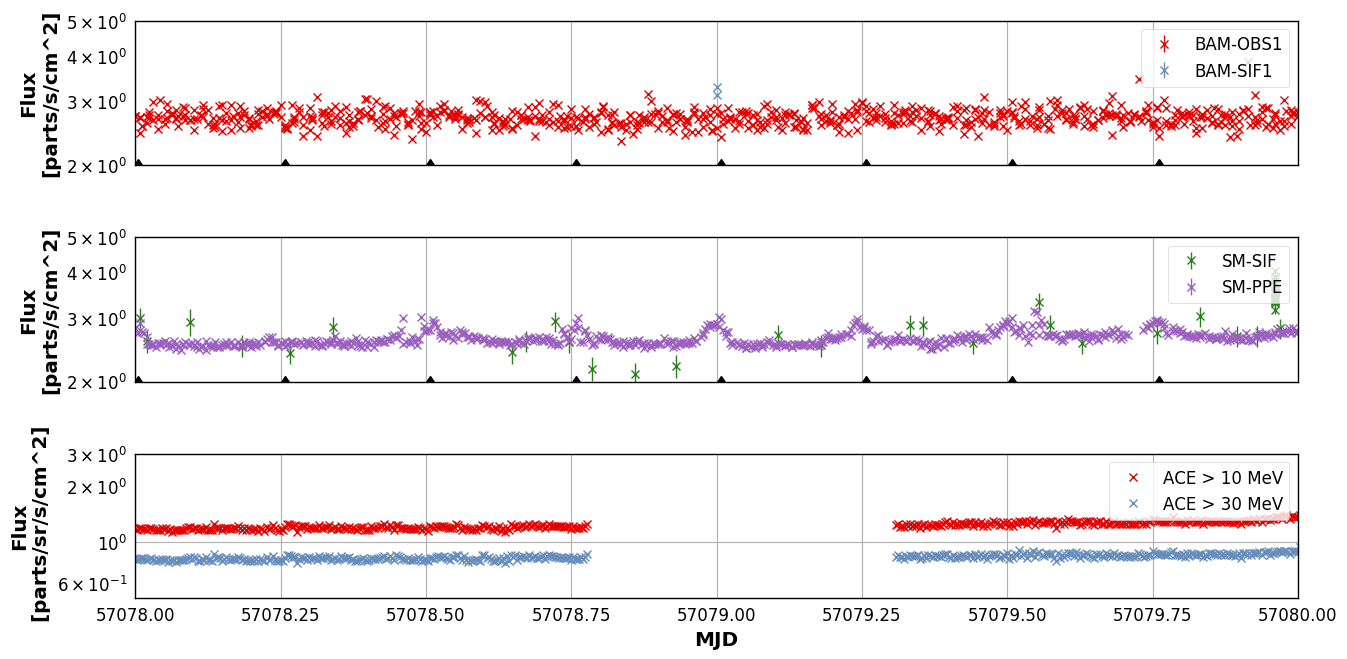

In [55]:
# Clear signs of modulation in the first two
#flareplot(56751,56758,1,ybam=(2,5),ysm=(2,5),yext=(.5,5),log=True,turns=spinturns)
#flareplot(56765,56770,1,ybam=(2,7),ysm=(2,7),yext=(.5,100),log=True,turns=spinturns)
#flareplot(56783.5,56786.5,1,ybam=(2,5),ysm=(2,5),yext=(.5,5),log=True,turns=spinturns)


# Strongly modulated and timing difference in first; second also has some cuts
#flareplot(56813,56818,1,ybam=(2,4),ysm=(2,4),yext=(.5,2),log=True,turns=spinturns)
#flareplot(56818,56828,1,ybam=(2,4),ysm=(2,4),yext=(.5,2),log=True,turns=spinturns)


# Nothing major
#flareplot(56901.5,56910,1,ybam=(2,10),ysm=(2,10),yext=(.5,150),log=True,turns=spinturns)
#flareplot(56910.5,56913.5,1,ybam=(2,20),ysm=(2,20),yext=(.5,150),log=True,turns=spinturns)


# strong modulation, different timing?
#flareplot(57012,57016,1,ybam=(2,10),ysm=(2,10),yext=(.5,10),log=True,turns=spinturns)


# very strong modulation
#flareplot(57049,57056,1,ybam=(2,5),ysm=(2,5),yext=(.5,5),log=True,turns=spinturns)
#flareplot(57074,57085,1,ybam=(2,5),ysm=(2,5),yext=(.5,3),log=True,turns=spinturns)
flareplot(57078,57080,1,ybam=(2,5),ysm=(2,5),yext=(.5,3),log=True,turns=spinturns) # to look for spin-enhancements


# some modulation in 2 and 3, the entire flare looks different
#flareplot(57191,57194,1,ybam=(2,6),ysm=(2,6),yext=(.5,70),log=True,turns=spinturns)
#flareplot(57194,57198.5,1,ybam=(2,15),ysm=(2,15),yext=(.5,700),log=True,turns=spinturns)
#flareplot(57198.5,57206,1,ybam=(2,6),ysm=(2,6),yext=(.5,70),log=True,turns=spinturns)


# weak modulation
#flareplot(57285,57287.5,1,ybam=(2,10),ysm=(2,10),yext=(.5,10),log=True,turns=spinturns)
#flareplot(57295,57300,1,ybam=(2,4),ysm=(2,4),yext=(.5,5),log=True,turns=spinturns)


# nothing visible
#flareplot(57324,57328,1,ybam=(2,10),ysm=(2,10),yext=(.5,150),log=True,turns=spinturns)


# very noticeable modulation
#flareplot(57380,57395,1,ybam=(2,6),ysm=(2,6),yext=(.5,70),log=True,turns=spinturns)


# these flares are hardly detected
#flareplot(57463,57465,1,ybam=(2,6),ysm=(2,6),yext=(.5,5),log=True,turns=spinturns)
#flareplot(57495,57500,1,ybam=(2,6),ysm=(2,6),yext=(.5,5),log=True,turns=spinturns)
#flareplot(57523.5,57526,1,ybam=(2,6),ysm=(2,6),yext=(.5,5),log=True,turns=spinturns)

# No modulation? The flare looks very different in SM
#flareplot(57948,57951,1,ybam=(2,50),ysm=(2,50),yext=(.5,70),log=True,turns=spinturns)

# first: Some modulaiton, especially at low flux
# second: Some noticeable when zooming in (in y)
#flareplot(58000,58006,1,ybam=(2,30),ysm=(2,30),yext=(.5,1000),log=True,turns=spinturns)
#flareplot(58006,58012,1,ybam=(2,400),ysm=(2,400),yext=(.5,20000),log=True,turns=spinturns)

# Dummy period with strong stray light
#flareplot(57679,57682,1,ybam=(3,4),ysm=(3,4),yext=(.5,3),log=False,turns=spinturns)


One interesting thing: The modulation seems to generally show up whenever we're at the turnaround, in BOTH SM1 and SM2!

Spin phase 180 degrees is whenever the FPA is facing the sun

In [4]:
orbdat = fits.getdata('../datasets/Position/CorotatingOrbit.fits')

T = orbdat["TIME"]
x = orbdat["X"]
y = orbdat["Y"]
z = orbdat["Z"]

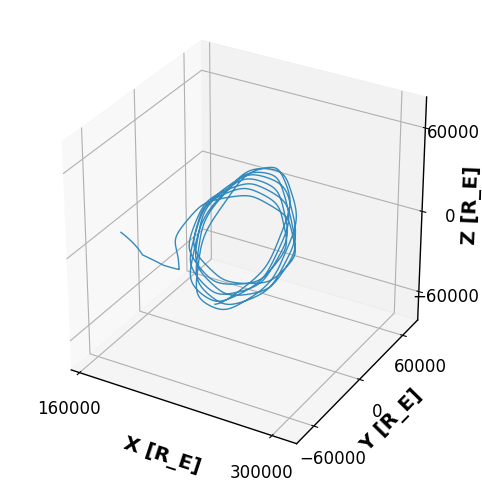

In [24]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.set_xlim((1e9/6.371e3,2e9/6.371e3))
ax.set_ylim((-5e8/6.371e3,5e8/6.371e3))
ax.set_zlim((-5e8/6.371e3,5e8/6.371e3))

ax.set_xlabel('X [R_E]')
ax.set_ylabel('Y [R_E]')
ax.set_zlabel('Z [R_E]')

ax.set_xticks([160000, 300000])
ax.set_yticks([-60000, 0, 60000])
ax.set_zticks([-60000, 0, 60000])


ax.plot(xs=x/6.371e3,ys=y/6.371e3,zs=z/6.371e3)

#plt.savefig('../../presentation_imgs/3D_Orbit.pdf',bbox_inches='tight')